In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset
from models.rocket import ROCKET
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.misc import set_random_state
from utils.path import config_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Rocket parameters
NUM_KERNELS = 1000
NORMALIZE = True

# Classifier parameters
REG_FACTOR = 1e5

## Initialize Datasets and Dataloaders

In [2]:
with open(f'{config_path}/leif.yaml', 'r') as reader:
    config = load_yaml(reader, Loader=FullLoader)

processor = Leif(config)
# Initialize Datasets
train_ds = KIDataset(data_processor=processor, train=True)
test_ds = KIDataset(data_processor=processor, train=False)
if BINARY_CLF:
    binarize(train_ds)
    binarize(test_ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=train_ds.x.shape[0],
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
test_dl = DataLoader(test_ds, batch_size=test_ds.x.shape[0])

loading files: 0files [00:00, ?files/s]

skipped 1 files (position max value outlier)
skipped 5 files (position snr outlier)
skipped 41 files (position mean velocity outlier)
skipped 1 files (drift max value outlier)
skipped 3 files (drift snr outlier)
skipped 1 files (drift mean velocity outlier)
skipped 2 files (no target movement)


segmenting time series: 100%|██████████| 156/156 [00:09<00:00, 16.09ts/s]


loading files: 0files [00:00, ?files/s]

segmenting time series: 100%|██████████| 89/89 [00:05<00:00, 16.09ts/s]


## Initialize Rocket and classifier

In [6]:
# Initialize Rocket
rocket = ROCKET(c_in=train_ds.x.shape[1],
                seq_len=train_ds.x.shape[2],
                n_kernels=NUM_KERNELS,
                normalize=NORMALIZE)

# Initialize Classifier
clf = RidgeClassifier(alpha=REG_FACTOR, random_state=SEED)

## Fit Model

In [4]:
# Batch is entire dataset
train_batch = next(iter(train_dl))

# Perform ROCKET transformation stage
features = rocket(train_batch.x)

# Fit Classifier
clf.fit(features, train_batch.y.numpy())

RidgeClassifier(alpha=100000.0, random_state=42)

## Evaluate on segment classification

Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.37      0.61      0.46       297
          PD       0.76      0.55      0.64       682

    accuracy                           0.56       979
   macro avg       0.56      0.58      0.55       979
weighted avg       0.64      0.56      0.58       979



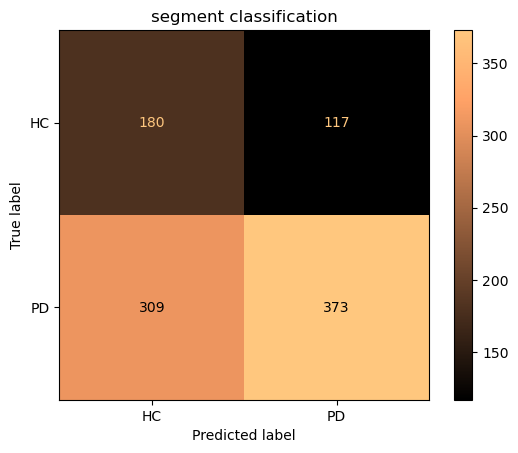

In [5]:
labels = ['HC', 'PD']
test_batch = next(iter(test_dl))

# Perform ROCKET transformation stage
test_features = rocket(test_batch.x)

# Make predictions on test set
pred = clf.predict(test_features)

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='copper')
figure.ax_.set_title('segment classification')
plt.show()